In [2]:
import os
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report
from src.helpers.project_paths import DATA_PATH

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "bank_data.csv"))
df = df.iloc[:,:-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [8]:
has_churn_rate_columns = any([True if x.find('chrun_rate') != -1 else False for x in list(df.columns)])
has_churn_rate_columns

False

In [6]:
df.shape

(10127, 21)

In [8]:
df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [1]:
df.describe()

NameError: name 'df' is not defined

In [10]:
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [9]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

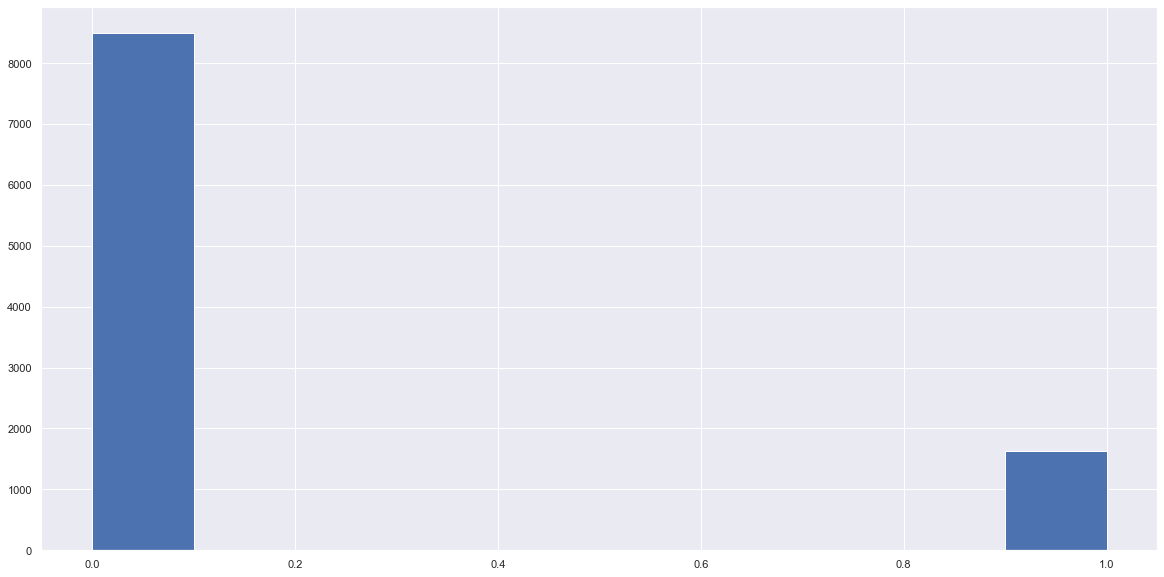

In [12]:
plt.figure(figsize=(20,10)) 
df['Churn'].hist();

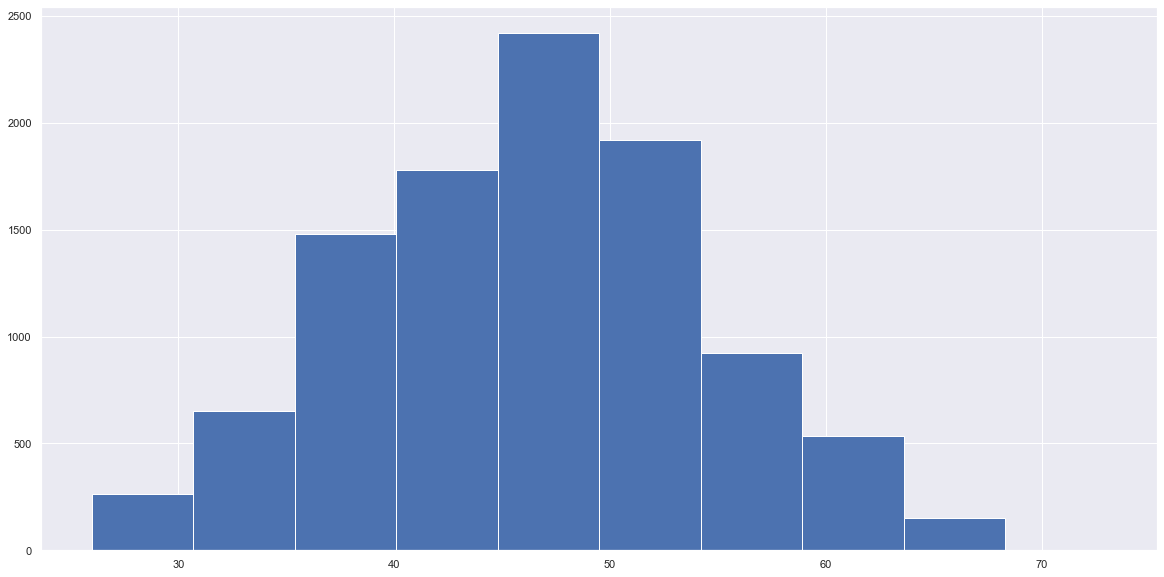

In [13]:
plt.figure(figsize=(20,10)) 
df['Customer_Age'].hist();

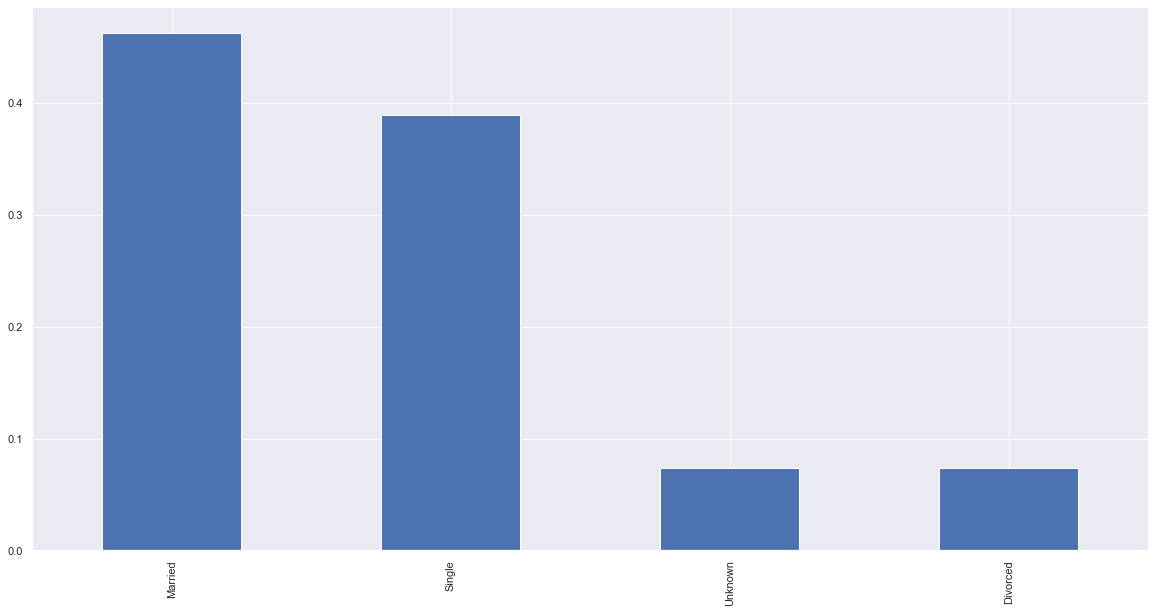

In [14]:
plt.figure(figsize=(20,10)) 
df.Marital_Status.value_counts('normalize').plot(kind='bar');

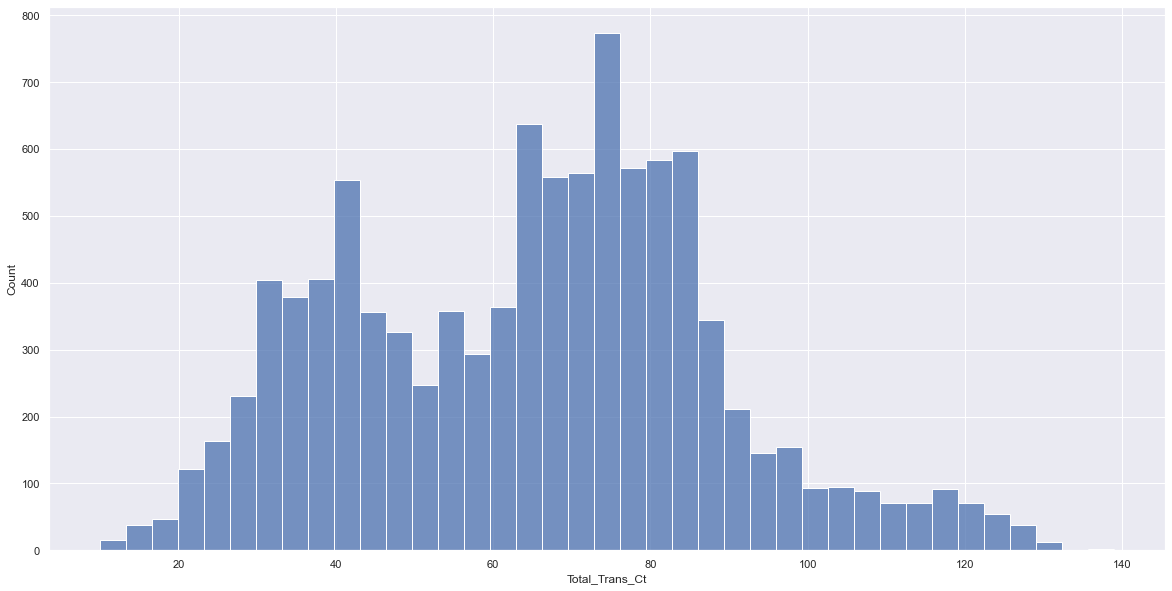

In [15]:
plt.figure(figsize=(20,10)) 
sns.histplot(df['Total_Trans_Ct']);

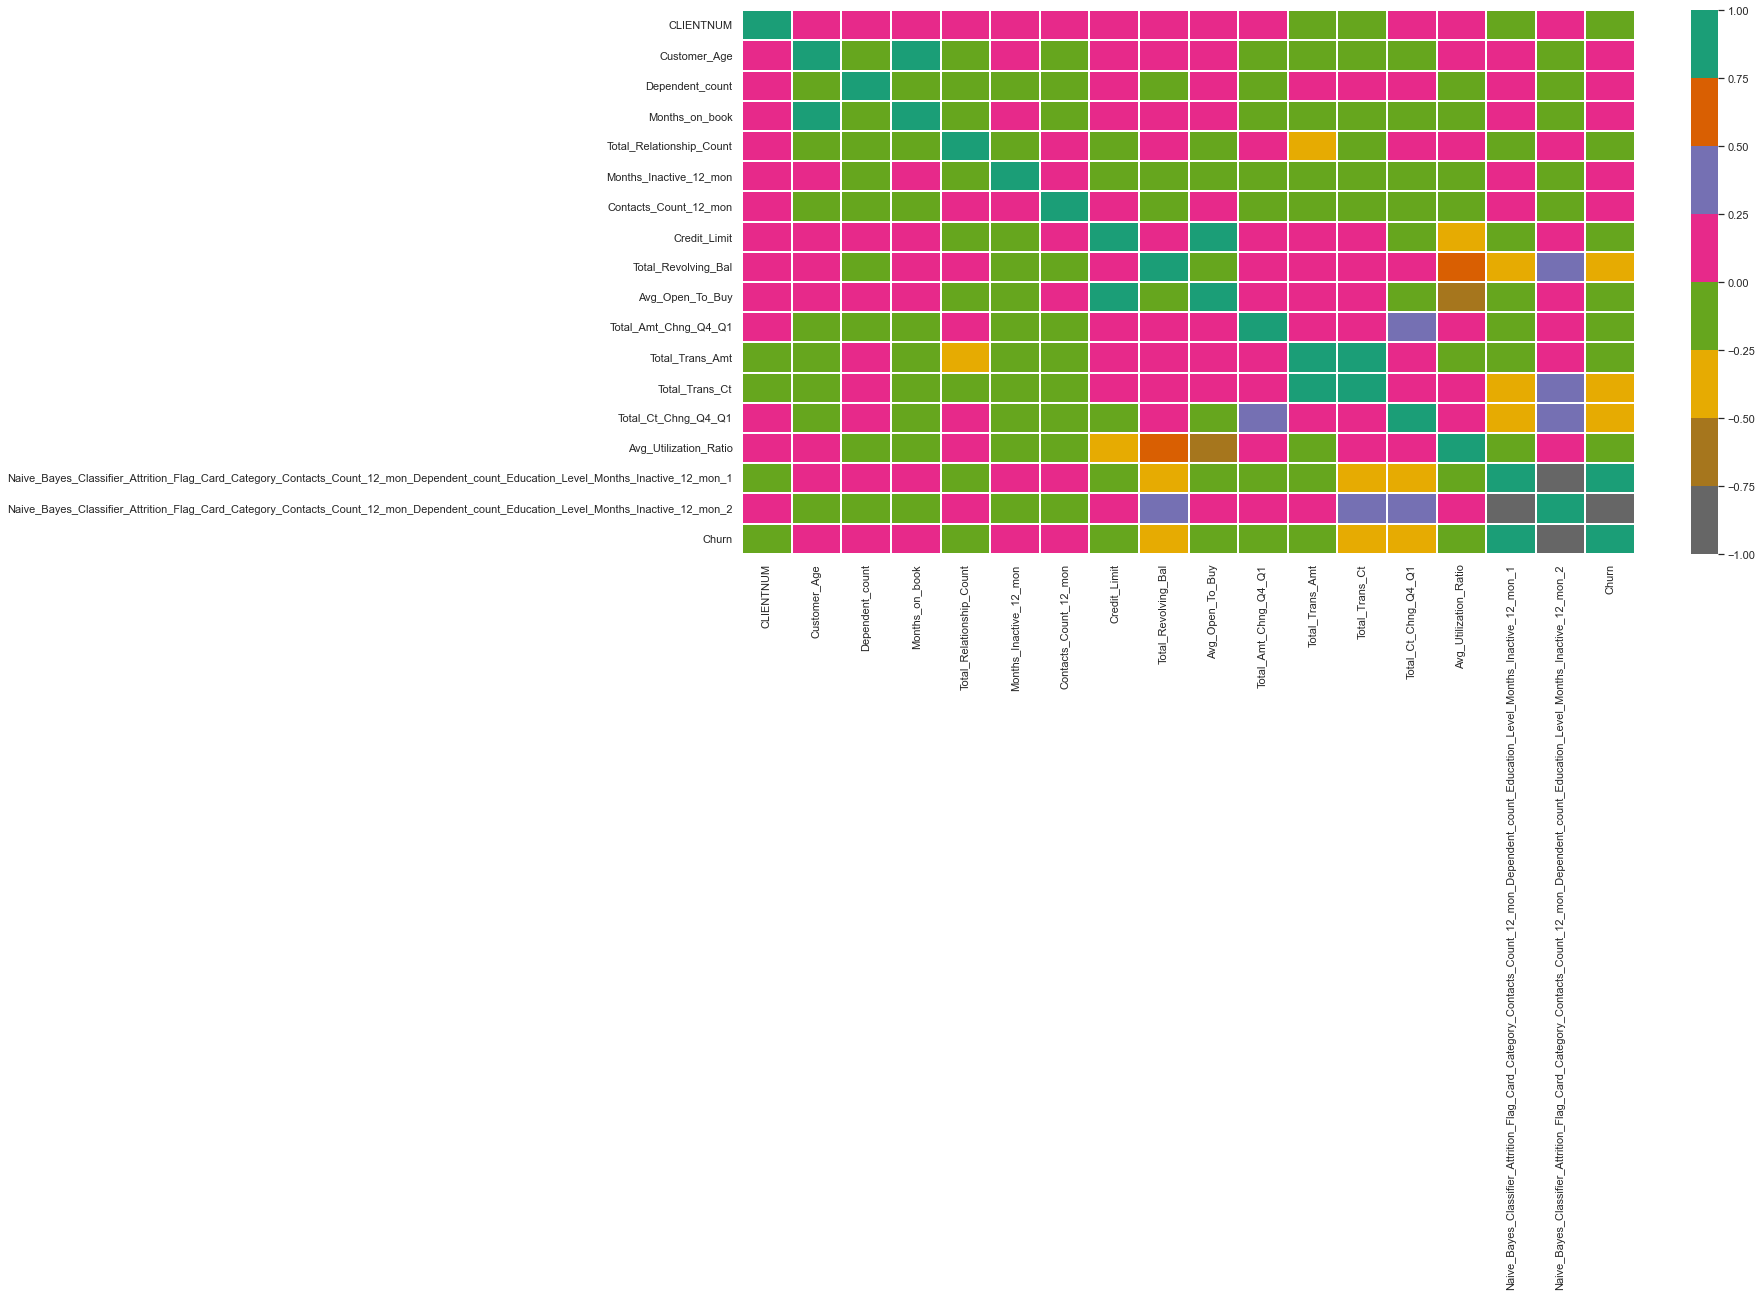

In [16]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
plt.show()

In [17]:
y = df['Churn']

In [18]:
X = pd.DataFrame()

In [19]:
# gender encoded column
gender_lst = []
gender_groups = df.groupby('Gender').mean()['Churn']

for val in df['Gender']:
    gender_lst.append(gender_groups.loc[val])

df['Gender_Churn'] = gender_lst    
#education encoded column
edu_lst = []
edu_groups = df.groupby('Education_Level').mean()['Churn']

for val in df['Education_Level']:
    edu_lst.append(edu_groups.loc[val])

df['Education_Level_Churn'] = edu_lst

#marital encoded column
marital_lst = []
marital_groups = df.groupby('Marital_Status').mean()['Churn']

for val in df['Marital_Status']:
    marital_lst.append(marital_groups.loc[val])

df['Marital_Status_Churn'] = marital_lst

#income encoded column
income_lst = []
income_groups = df.groupby('Income_Category').mean()['Churn']

for val in df['Income_Category']:
    income_lst.append(income_groups.loc[val])

df['Income_Category_Churn'] = income_lst

#card encoded column
card_lst = []
card_groups = df.groupby('Card_Category').mean()['Churn']
 
for val in df['Card_Category']:
    card_lst.append(card_groups.loc[val])

df['Card_Category_Churn'] = card_lst
    

In [20]:
keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

X[keep_cols] = df[keep_cols]

In [21]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [22]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

# grid search
rfc = RandomForestClassifier(random_state=42)
lrc = LogisticRegression()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.70      0.46      0.56       496

    accuracy                           0.88      3039
   macro avg       0.80      0.71     

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


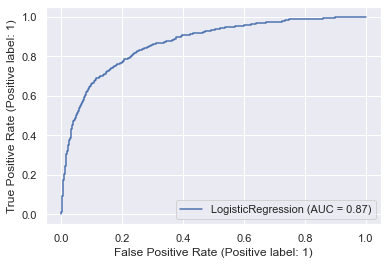

In [23]:
lrc_plot = plot_roc_curve(lrc, X_test, y_test)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


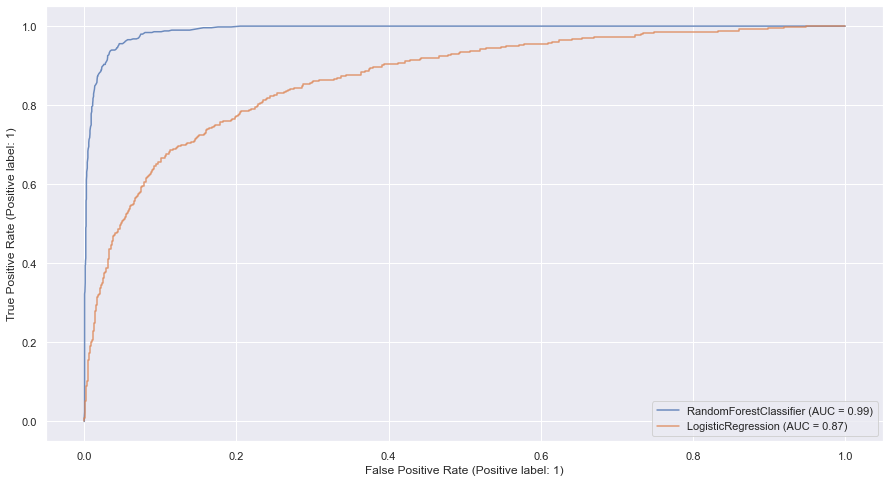

In [24]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [25]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './docs/models/rfc_model.pkl')
joblib.dump(lrc, './docs/models/logistic_model.pkl')

['./docs/models/logistic_model.pkl']

In [26]:
rfc_model = joblib.load('./docs/models/rfc_model.pkl')
lr_model = joblib.load('./docs/models/logistic_model.pkl')

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


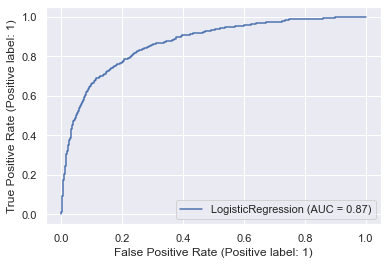

In [27]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


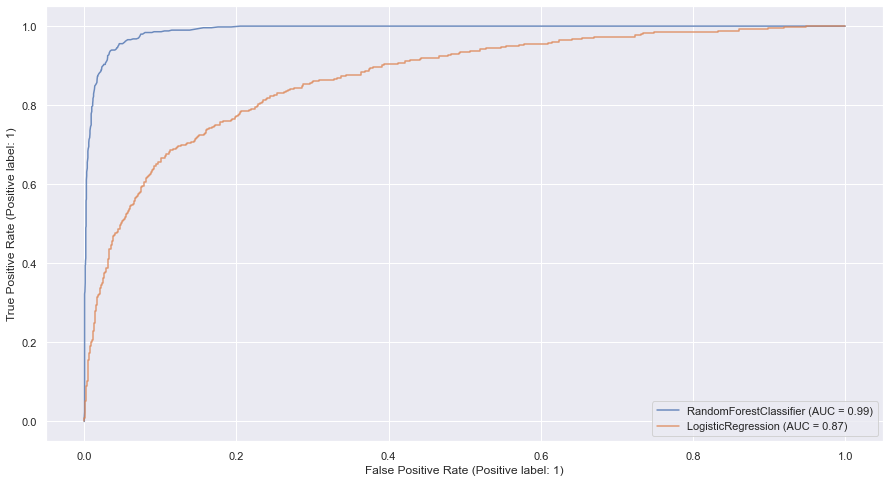

In [28]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

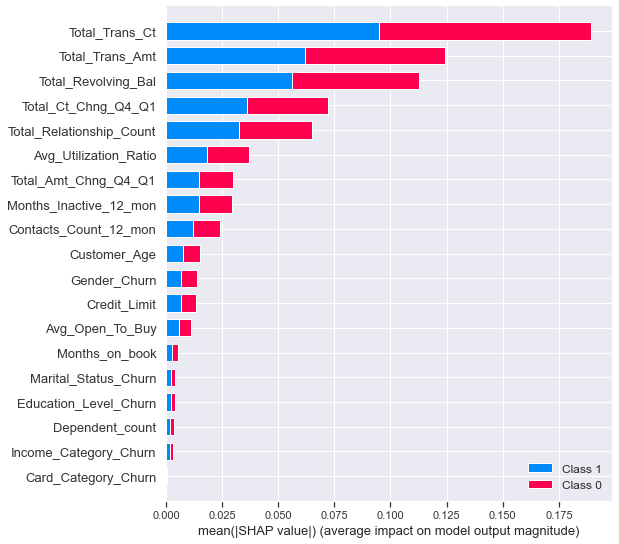

In [29]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

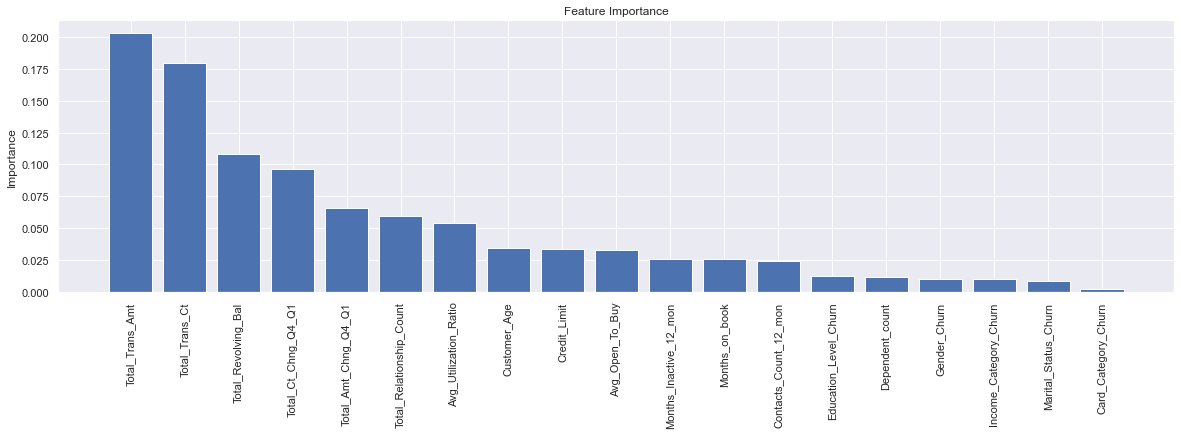

In [30]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

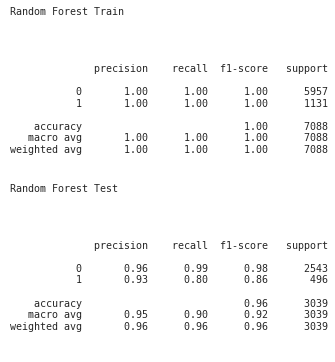

In [31]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');

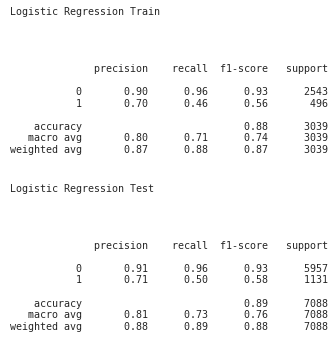

In [32]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');